In [1]:
# Import needed libraries
%pip install torch_geometric pulp
import numpy as np
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import scipy
import skimage as ski
import torchvision.transforms as T
from torch_geometric.transforms import ToSLIC
import pulp
import gdown
import time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 49.2 MB/s eta 0:00:00


In [2]:
# Download files that will be tested
!gdown https://drive.google.com/uc?id=1U3Cy8ZJoxHCCBLR4hrrGztsJq-F2Ea6N
!gdown https://drive.google.com/uc?id=17eSzKOYCNpXB1TOL4dDZTVmZou3vwhoa

Downloading...
From: https://drive.google.com/uc?id=1U3Cy8ZJoxHCCBLR4hrrGztsJq-F2Ea6N
To: /content/exact_dimension.jpg
100% 9.26M/9.26M [00:00<00:00, 53.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=17eSzKOYCNpXB1TOL4dDZTVmZou3vwhoa
To: /content/exact_dimension_edited.jpg
100% 11.3M/11.3M [00:00<00:00, 38.1MB/s]


In [3]:
def load_image(img_path):
    """
    Loads an image from the specified path and converts it from RGBA to RGB if necessary.

    Args:
        img_path (str): The file path to the image.

    Returns:
        ndarray: The image as a NumPy array. If the image is in RGBA format, it will be converted to RGB.

    Raises:
        FileNotFoundError: If the file does not exist or the path is invalid.
    """
    img = ski.io.imread(img_path)
    if len(img.shape) == 3:
        if img.shape[2] == 4:
            img = ski.color.rgba2rgb(img)
    return img

def crop_image(img,H0,H1,W0,W1):
    """
    Resizes the given image to the specified target size.

    Args:
        img (ndarray): The image to resize, represented as a NumPy array.
        H0 (int): The source height in pixels.
        H1 (int): The target height in pixels.
        W0 (int): The source wide in pixels.
        W1 (int): The target wide in pixels

    Returns:
        ndarray: The resized image as a NumPy array.

    Raises:
        ValueError: If the target size is not a tuple or if the dimensions are invalid.
    """
    return img[H0:H1,W0:W1,:]

In [4]:
def calculate_slic(segments_count):
    """
    Performs SLIC (Simple Linear Iterative Clustering) segmentation on an image and returns the segmented image.

    Args:
        segments_count (int): The desired number of superpixels to segment the image into.

    Returns:
        tuple:
            - img (ndarray): The rescaled image as a NumPy array.
            - islic (ndarray): The segmented image using SLIC, where each pixel is assigned to a superpixel.

    Raises:
        FileNotFoundError: If the specified image file ('exact_dimension_edited.jpg') is not found.
        ValueError: If the `segments_count` is not valid or negative.

    Notes:
        - The function crops and rescales the input image to 10% of its original size.
        - The SLIC segmentation is configured to use the Lab color space (via `convert2lab=True`).
        - The execution time for the segmentation is printed for performance monitoring.
    """
    start_time = time.time()

    # Image crop coordinates
    W0,W1,H0,H1 = (0, 1024, 0, 768)
    # Image size
    W,H = W1-W0, H1-H0
    # Desired number of superpixels
    n_segments = segments_count
    # SLIC parameters
    slic_pars = {
        'n_segments': n_segments,
        'compactness': 50.0,
        'channel_axis':2,
        'convert2lab': True
    }

    # Load and rescale the image
    img = ski.transform.rescale(load_image('exact_dimension_edited.jpg'),0.1, channel_axis=2)
    H,W,_ = img.shape

    # Perform SLIC segmentation
    islic = ski.segmentation.slic(
        img,
        **slic_pars
    )

    # Using PyTorch Tensors and transformations
    transform = T.Compose([T.ToTensor(), ToSLIC(**slic_pars)])

    # Measure execution time
    time_diff = time.time() - start_time
    print(f"Slic segmentation execution time for {segments_count} segments: {time_diff}s.")

    return img, islic

In [5]:
def calculate_route(segments_count):
    """
    Calculates an optimal route over superpixels generated using SLIC (Simple Linear Iterative Clustering) segmentation.

    Args:
        segments_count (int): The desired number of superpixels for the segmentation process.

    Returns:
        tuple:
            - img (ndarray): The rescaled image as a NumPy array.
            - islic (ndarray): The image segmented into superpixels using SLIC.
            - ti (Tensor): A PyTorch tensor containing superpixel data.
            - tpos (ndarray): An array of centroid positions for each superpixel.
            - tcol (ndarray): An array of mean colors for each superpixel.
            - W (int): The width of the processed image.
            - H (int): The height of the processed image.
            - route (list): A list of tuples representing the optimal route between superpixels.

    Raises:
        FileNotFoundError: If the image file ('exact_dimension_edited.jpg') is not found.
        ValueError: If `segments_count` is invalid or negative.

    Notes:
        - The function first performs SLIC segmentation and then calculates the optimal route through the superpixels using the Traveling Salesman Problem (TSP) formulation.
        - The distances between superpixel centroids are calculated using Euclidean distance.
        - The optimal path is determined using linear programming with the PuLP library.
    """
    start_time = time.time()

    # Image crop coordinates
    W0,W1,H0,H1 = (0, 1024, 0, 768)
    # Image size
    W,H = W1-W0, H1-H0
    # Desired number of superpixels
    n_segments = segments_count
    # SLIC parameters
    slic_pars = {
        'n_segments': n_segments,
        'compactness': 50.0,
        'channel_axis':2,
        'convert2lab': True
    }

    # Load and rescale the image
    img = ski.transform.rescale(load_image('exact_dimension_edited.jpg'),0.1, channel_axis=2)
    H,W,_ = img.shape

    # Perform SLIC segmentation
    islic = ski.segmentation.slic(
        img,
        **slic_pars
    )

    # Using PyTorch Tensors and transformations
    transform = T.Compose([T.ToTensor(), ToSLIC(**slic_pars)])

    # Measure execution time for segmentation
    time_diff = time.time() - start_time
    print(f"Slic segmentation execution time for {n_segments} segments: {time_diff}s.")

    start_time = time.time()

    # Tensor of the SLIC image
    ti = transform(img.copy())
    n_superpixels = ti.pos.shape[0]
    tpos = ti.pos.numpy() # Superpixel centroid positions
    tcol = ti.x.numpy() # Mean colors of superpixels

    # Calculate Euclidean distances between centroids
    dist = scipy.spatial.distance.cdist(tpos,tpos,metric='euclidean')

    # Initialize the Traveling Salesman Problem (TSP) model
    pplp = pulp.LpProblem('path_plan', pulp.LpMinimize)

    # Define all possible paths between superpixels
    id_paths = [
        (i,j)
        for i in range(n_superpixels)
        for j in range(n_superpixels)
    ]

    # Create binary decision variables for each path
    x = pulp.LpVariable.dicts('x', id_paths, cat='Binary')
    # Tour order variables to prevent subtours
    u = pulp.LpVariable.dicts('u', range(n_superpixels),
                              lowBound=1, upBound=n_superpixels, cat='Integer')
    # Objective function: Minimize the total distance traveled
    pplp += pulp.lpSum([dist[i,j] *x[i,j] for (i,j) in id_paths])

    # Constraints: No self-loops
    for i in range(n_superpixels):
        pplp += x[i, i] == 0
    # Constraints: Every superpixel is visited exactly once
    for i in range(n_superpixels):
        pplp += pulp.lpSum([x[i,j] for j in range(n_superpixels)]) == 1
        pplp += pulp.lpSum([x[k,i] for k in range(n_superpixels)]) == 1
    # Constraints: Prevent subtours (subtours are smaller loops within the tour)
    for (i,j) in id_paths:
        if i!=j and i !=0 and j!=0:
            pplp += u[i] - u[j] <= n_superpixels*(1-x[i,j]) -1

    # Solve the linear program to find the optimal route
    status = pplp.solve()
    print(status, pulp.LpStatus[status], pulp.value(pplp.objective))

    # Extract the optimal route based on decision variables
    route = [(i, j) for (i,j) in id_paths if pulp.value(x[i, j]) == 1]

    # Measure execution time for route calculation
    time_diff = time.time() - start_time
    print(f"Route calculation execution time for {n_segments} segments: {time_diff}s.")

    return img, islic, ti, tpos, tcol, W, H, route

In [6]:
def plot_single_slic(n_segments):
    """
    Plots the boundaries of superpixels generated using SLIC segmentation on an image.

    Args:
        n_segments (int): The number of superpixels to generate using SLIC segmentation.

    Returns:
        ndarray: The image with superpixel boundaries marked, as a NumPy array.

    Notes:
        - The function uses `calculate_slic` to perform SLIC segmentation on an image and then visualizes the result by marking the boundaries of the superpixels.
        - Superpixel boundaries are highlighted using `ski.segmentation.mark_boundaries`.
    """
    img, islic = calculate_slic(n_segments)

    return ski.segmentation.mark_boundaries(img, islic)

In [7]:
def plot_three_slics(begin, end):
    """
    Plots a 2x2 grid showing the original image and three different SLIC segmentations with varying numbers of superpixels.

    Args:
        begin (int): The starting number of superpixels for the SLIC segmentation.
        end (int): The maximum number of superpixels for the final segmentation.

    Returns:
        None: The function directly plots the image grid using Matplotlib.

    Notes:
        - The original image is displayed in the top-left corner.
        - The image is rescaled to 10% of its original size for faster processing.
        - Matplotlib is used to create a grid of images for comparison purposes.
    """
    fig,axs = plt.subplots(ncols=2, nrows=2)

    # Load and rescale the image
    img = ski.transform.rescale(load_image('exact_dimension_edited.jpg'),0.1, channel_axis=2)

    iter = (end-begin)/3
    x = begin
    # Iterate over the 2x2 grid to plot the original image and SLIC segmentations
    for i in range(0, 2):
      for j in range(0, 2):
        if i + j == 0:
          # Plot the original image in the top-left corner
          axs[0, 0].set_title('Original photo')
          axs[0, 0].imshow(img)
        else:
          # Plot SLIC segmentation in other subplots
          axs[i, j].set_title(f'SLIC - {x} segments')
          axs[i, j].imshow(plot_single_slic(x))
          x += iter

In [8]:
def plot_superpix(n_segments):
    """
    Plots the superpixel segmentation, centroids, and optimal tour path through the superpixels.

    Args:
        n_segments (int): The desired number of superpixels for the SLIC segmentation.

    Returns:
        None: This function displays multiple plots using Matplotlib to visualize superpixel segmentation, centroids, and the calculated optimal tour.

    Notes:
        - The function performs SLIC segmentation and calculates an optimal tour through the superpixels.
        - The original image, segmented superpixels, and centroids are plotted alongside the optimal tour.
        - Each superpixel is represented as a circle with a radius determined by its size in the image.
        - The optimal tour between the superpixels is visualized with arrows indicating the route.
        - A spline (smoothed curve) is also plotted for the tour using the waypoints.

    Plots:
        - Original Image: The original rescaled image.
        - SLIC Segmentation: The image with superpixel boundaries highlighted.
        - Centroids: A plot showing the centroids of each superpixel with a circle radius proportional to its area.
        - Tour: A plot displaying the calculated tour with numbered superpixel waypoints and arrows connecting them.
    """
    start_time = time.time()

    # Calculate the SLIC segmentation and optimal route
    img, islic, ti, tpos, tcol, W, H, route = calculate_route(n_segments)

    # Create a 2x1 grid of plots
    fig,axs = plt.subplots(ncols=2, nrows=1)

    # Plot the original image
    axs[0].set_title('original')
    axs[0].imshow(img)

    # Plot the SLIC segmentation with superpixel boundaries
    axs[1].set_title('slic segmentation')
    axs[1].imshow(ski.segmentation.mark_boundaries(img, islic))

    # Calculate the radius of each superpixel based on image dimensions
    n_superpixels = ti.pos.shape[0]
    pixels_per_superpix = (W*H)/n_superpixels
    radius = (pixels_per_superpix/np.pi)**0.5
    radius = max(radius, 1) # Ensure a minimum radius of 1 pixel

    # Create another 2x1 grid for centroid and tour plots
    fig,axs = plt.subplots(ncols=2, nrows=1,sharex=True, sharey=True)

    # Plot superpixel centroids
    axs[0].set_aspect(1, share=True)
    axs[0].set_xlim(0,W)
    axs[0].set_ylim(H,0)
    axs[0].set_title('slic centroids')

    for k, pos in enumerate(tpos):
        circle = plt.Circle(pos,radius, color=tcol[k], alpha=0.5)
        axs[0].add_patch(circle)
        axs[0].plot(pos[0], pos[1], 'o', ms=1, color=tcol[k], alpha=1)

    # Plot the optimal tour
    delta = radius/4
    axs[1].set_title('tour')

    for k in range(n_superpixels):
        col = tcol[k].reshape(1,-1)
        if k == 0:
            axs[1].scatter(tpos[k,0], tpos[k,1], c=col)
            axs[1].text(tpos[k,0] + delta, tpos[k,1] + delta, 'base')
        else:
            axs[1].scatter(tpos[k,0], tpos[k,1], c=col)
            axs[1].text(tpos[k,0]+delta, tpos[k,1]+delta, f'{k}')

    # Draw the route between superpixels
    arrowprops = dict(
        arrowstyle='->',
        connectionstyle='arc3',
        edgecolor='blue'
    )
    route_waypoints = []
    for i, j in route:
        axs[1].annotate(
        '',
        xy=[tpos[j,0], tpos[j,1]],
        xytext=[tpos[i,0], tpos[i,1]],
        arrowprops=arrowprops
        )
        route_waypoints.append([tpos[j,0], tpos[j,1]])

    # Combine route with waypoints
    route_combined = []
    point_waypoint_pair = []
    for i in range(len(route)):
        route_combined.append([route[i], route_waypoints[i]])
        point_waypoint_pair.append([route[i], route_waypoints[i]])

    # Order the route waypoints and generate a spline for the smoothed path
    ordered_waypoints = order_route_waypoints(point_waypoint_pair)
    x_spline_route, y_spline_route = plot_spline(ordered_waypoints, n_segments)

    # Print the smoothed path coordinates
    print_smoothed_path(x_spline_route, y_spline_route)

In [9]:
def print_smoothed_path(x_spline_route, y_spline_route, print_waypoints = False):
    """
    Prints the smoothed path waypoints and stores them in a list.

    Args:
        x_spline_route (list or ndarray): The x-coordinates of the smoothed path.
        y_spline_route (list or ndarray): The y-coordinates of the smoothed path.
        print_waypoints (bool, optional): If True, prints each waypoint's index and coordinates (x, y). Defaults to False.

    Notes:
        - The function creates a list of [x, y] coordinate pairs from the input x and y values, representing waypoints along a smoothed path.
        - If `print_waypoints` is set to True, it prints each waypoint with its index and coordinates.
    """
    smoothed_path_waypoints = []

    # Optionally print the waypoints
    if print_waypoints:
        print("Smoothed path waypoints: ")
    for i in range(len(x_spline_route)):
        smoothed_path_waypoints.append([x_spline_route[i], y_spline_route[i]])

        # Print each waypoint if requested
        if print_waypoints:
            print(f"Point nr: {i}   X coord: {x_spline_route[i]}    Y coord: {y_spline_route[i]}")

In [10]:
def order_route_waypoints(point_waypoint_pair):
    """
    Orders the waypoints along the route, starting from a designated starting point, and returns them in sequence.

    Args:
        point_waypoint_pair (list): A list of tuples, where each tuple contains a point and its corresponding waypoint.
                                    Format: [(point, [x, y]), ...]

    Returns:
        list: A list of ordered waypoints (as tuples of coordinates) along the route, starting and ending at the start point.

    Notes:
        - The function starts from a specified initial point (0 by default) and iteratively follows the route by looking up the next point.
        - The ordered waypoints are returned as a list of tuples, with each tuple representing an (x, y) coordinate.
        - The result ensures that the route is completed by returning to the starting point at the end.
    """
    # Start from the initial point (default is 0)
    start = 0
    current = start
    ordered_route_waypoints = []
    route = []

    # Extract the route points from the point-waypoint pairs
    for i in range(len(point_waypoint_pair)):
        route.append(point_waypoint_pair[i][0])

    # Create a dictionary to facilitate finding the next point in the route
    route_dict = {i: j for (i, j) in route}

    # Loop until we return to the starting point
    while True:
        next_point = route_dict[current]
        ordered_route_waypoints.append(point_waypoint_pair[current][1])
        current = next_point
        if current == start:
            break

    # Ensure the result starts and ends at the last visited waypoint (for closed-loop routes)
    result = []
    result.append(ordered_route_waypoints[-1])
    for i in range(len(ordered_route_waypoints)):
        result.append(ordered_route_waypoints[i])

    # Convert waypoints to tuples if necessary
    result = [tuple(pair) for pair in result]

    return result

In [11]:
def plot_spline(waypoints, n_segments):
    """
    Plots a spline curve based on the provided waypoints and displays the original waypoints.

    Args:
        waypoints (list): A list of tuples representing the waypoints, where each tuple is in the format (x, y).
        n_segments (int): The number of segments used in the route for smoothing.

    Returns:
        tuple: A tuple containing the x and y coordinates of the smoothed spline.

    Notes:
        - The function uses SciPy's spline interpolation to create a smooth curve that passes through the given waypoints.
        - The original waypoints are plotted as red dots, and the smoothed spline is plotted as a green line.
        - The function measures and prints the time taken to smooth the route based on the number of segments.
    """
    start_time = time.time()

    # Initialize lists for x and y coordinates
    x = []
    y = []

    # Extract x and y coordinates from waypoints
    for waypoint in waypoints:
        x.append(waypoint[0])
        y.append(waypoint[1])

    # Generate spline representation
    tck, *rest = interpolate.splprep([x, y], s=0)
    u = np.linspace(0, 1, num=500)
    smooth = interpolate.splev(u, tck)

    # Plot original waypoints and smoothed spline
    plt.plot(x, y, 'ro', smooth[0], smooth[1], 'g-')

    # Calculate and print the time taken for smoothing
    time_diff = time.time() - start_time
    print(f"Route smoothing time for {n_segments} segments: {time_diff}s.")

    return smooth

Slic segmentation execution time for 50 segments: 16.6083767414093s.
1 Optimal 3751.385486228311
Route calculation execution time for 50 segments: 247.99377989768982s.
Route smoothing time for 50 segments: 0.013444900512695312s.


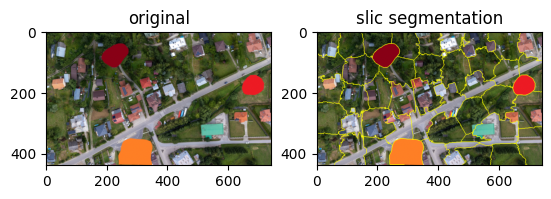

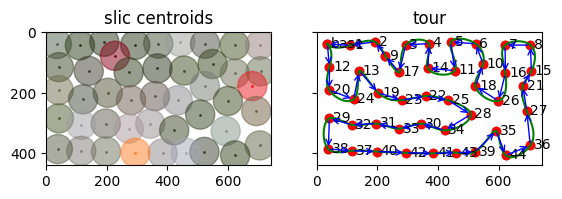

In [12]:
# Exported ordered route waypoints
plot_superpix(50)

Slic segmentation execution time for 20: 9.298744440078735s.
Slic segmentation execution time for 40: 8.141713857650757s.
Slic segmentation execution time for 50: 8.918520450592041s.


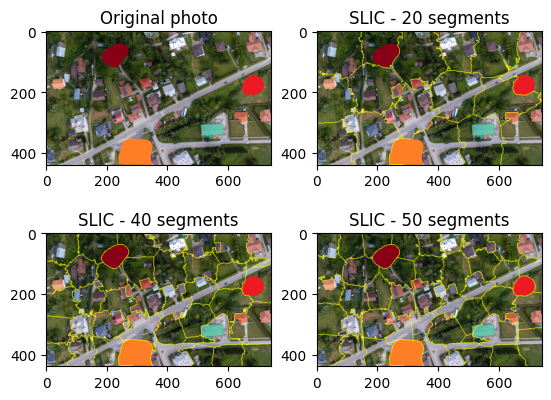

In [ ]:
# Exported edited image SLIC segmentation
plot_three_slics(20, 60)